In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, stride):
        super(InvertedResidualBlock, self).__init__()

        self.stride = stride
        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expansion, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, in_channels * expansion, kernel_size=3, stride=stride, padding=1, groups=in_channels * expansion, bias=False),
            nn.BatchNorm2d(in_channels * expansion),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer = nn.Sequential(
            nn.Conv2d(in_channels * expansion, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer(out)
        out = self.pointwise_layer(out)

        # if self.stride == 1:
        #     out = out + x

        return out

class InvertedResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, t=6, stride=1):
        super(InvertedResidualBlockTranspose, self).__init__()

        self.stride = stride

        self.expansion_layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.depthwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, in_channels * t, kernel_size=3, stride=stride, padding=1,
                               output_padding=(0 if stride == 1 else 1), groups=in_channels * t, bias=False),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True)
        )

        self.pointwise_layer_transpose = nn.Sequential(
            nn.ConvTranspose2d(in_channels * t, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        out = self.expansion_layer(x)
        out = self.depthwise_layer_transpose(out)
        out = self.pointwise_layer_transpose(out)

        return out


class MobileNetV2CAE(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(MobileNetV2CAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            InvertedResidualBlock(32, 16, 1, 1),
            InvertedResidualBlock(16, 24, 6, 2),
            InvertedResidualBlock(24, 24, 6, 1),
            InvertedResidualBlock(24, 32, 6, 2),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 32, 6, 1),
            InvertedResidualBlock(32, 64, 6, 2),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 64, 6, 1),
            InvertedResidualBlock(64, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 96, 6, 1),
            InvertedResidualBlock(96, 160, 6, 2),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 160, 6, 1),
            InvertedResidualBlock(160, 320, 6, 1)
        )

        self.decoder = nn.Sequential(
            InvertedResidualBlockTranspose(320, 160, 6, 1),
            InvertedResidualBlockTranspose(160, 160, 6, 1),
            InvertedResidualBlockTranspose(160, 160, 6, 2),
            InvertedResidualBlockTranspose(160, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 96, 6, 1),
            InvertedResidualBlockTranspose(96, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 64, 6, 1),
            InvertedResidualBlockTranspose(64, 32, 6, 2),
            InvertedResidualBlockTranspose(32, 32, 6, 1),
            InvertedResidualBlockTranspose(32, 32, 6, 1),
            InvertedResidualBlockTranspose(32, 24, 6, 2),
            InvertedResidualBlockTranspose(24, 24, 6, 1),
            InvertedResidualBlockTranspose(24, 16, 6, 2), # Change stride from 1 to 2
            nn.ConvTranspose2d(16, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = MobileNetV2CAE(in_channels=3)

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


print(summary(model, input_size=(3, 32, 32), device=device.type))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           1,024
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]             288
       BatchNorm2d-8           [-1, 32, 16, 16]              64
             ReLU6-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             512
      BatchNorm2d-11           [-1, 16, 16, 16]              32
InvertedResidualBlock-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 96, 16, 16]           1,536
      BatchNorm2d-14           [-1,

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Instantiate the model
model = MobileNetV2CAE(in_channels=3).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [4]:
# Training the model
model.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/25], Step [100/500], Loss: 0.2429
Epoch [1/25], Step [200/500], Loss: 0.2293
Epoch [1/25], Step [300/500], Loss: 0.2348
Epoch [1/25], Step [400/500], Loss: 0.2227
Epoch [1/25], Step [500/500], Loss: 0.2216
Epoch [2/25], Step [100/500], Loss: 0.2021
Epoch [2/25], Step [200/500], Loss: 0.1912
Epoch [2/25], Step [300/500], Loss: 0.2007
Epoch [2/25], Step [400/500], Loss: 0.2052
Epoch [2/25], Step [500/500], Loss: 0.1878
Epoch [3/25], Step [100/500], Loss: 0.1790
Epoch [3/25], Step [200/500], Loss: 0.1663
Epoch [3/25], Step [300/500], Loss: 0.1886
Epoch [3/25], Step [400/500], Loss: 0.1666
Epoch [3/25], Step [500/500], Loss: 0.1628
Epoch [4/25], Step [100/500], Loss: 0.1653
Epoch [4/25], Step [200/500], Loss: 0.1642
Epoch [4/25], Step [300/500], Loss: 0.1663
Epoch [4/25], Step [400/500], Loss: 0.1759
Epoch [4/25], Step [500/500], Loss: 0.1460
Epoch [5/25], Step [100/500], Loss: 0.1573
Epoch [5/25], Step [200/500], Loss: 0.1462
Epoch [5/25], Step [300/500], Loss: 0.1593
Epoch [5/25

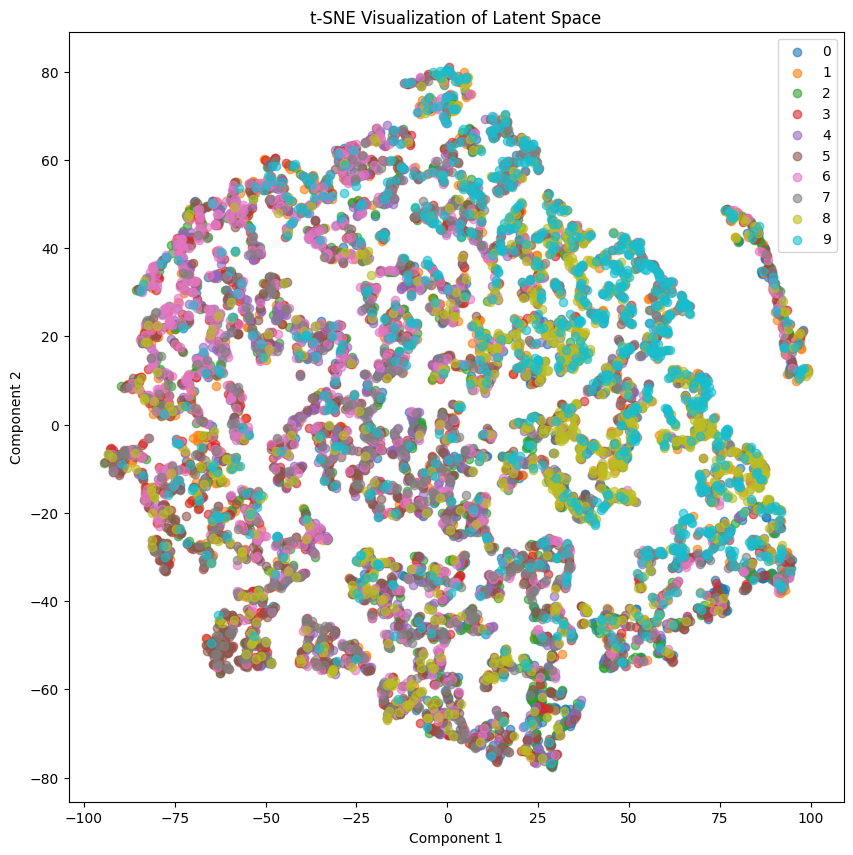

In [5]:
model.eval()

latent_space = []
labels = []

with torch.no_grad():
    for i, (images, lbls) in enumerate(test_loader):
        images = images.to(device)
        encoded = model.encoder(images).view(images.size(0), -1).cpu().numpy()
        latent_space.append(encoded)
        labels.extend(lbls)

latent_space = np.vstack(latent_space)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
latent_2D = tsne.fit_transform(latent_space)

# Visualize the latent space using t-SNE
plt.figure(figsize=(10, 10))
for i in range(10):
    indices = labels == i
    plt.scatter(latent_2D[indices, 0], latent_2D[indices, 1], label=f'{i}', alpha=0.6)

plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Latent Space')
plt.show()
